<a href="https://colab.research.google.com/github/SamudiniD/Efficient-Denoising-for-single-band-astronomical-images/blob/main/SDSS_Image_Preprocessing_FITS_to_NPY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
import numpy as np

def combine_and_pad(input_dir, output_file):
    """
    Loads all .npy files from input_dir, pads them to the same shape if necessary,
    stacks them along a new first axis, and saves the result to output_file.
    """
    # 1. Find all .npy files
    paths = sorted(glob.glob(os.path.join(input_dir, '*.npy')))
    if not paths:
        raise FileNotFoundError(f"No .npy files found in {input_dir}")

    # 2. Load arrays into a list
    arrays = [np.load(p) for p in paths]

    # 3. Inspect shapes
    shapes = [a.shape for a in arrays]
    unique_shapes = set(shapes)
    print(f"[{os.path.basename(input_dir)}] Unique shapes: {unique_shapes}")

    # 4. Compute the maximum size along each dimension
    ndim = arrays[0].ndim
    max_shape = tuple(max(s[i] for s in shapes) for i in range(ndim))
    print(f"[{os.path.basename(input_dir)}] Will pad to: {max_shape}")

    # 5. Pad each array to max_shape
    padded = []
    for a in arrays:
        pad_width = [(0, max_shape[i] - a.shape[i]) for i in range(ndim)]
        padded.append(np.pad(a, pad_width, mode='constant', constant_values=0))

    # 6. Stack along a new first axis and save
    combined = np.stack(padded, axis=0)
    np.save(output_file, combined)
    print(f"Saved '{os.path.basename(output_file)}' with shape {combined.shape}\n")


if __name__ == "__main__":
    # If running in Colab, uncomment these lines to mount Drive first:
    # from google.colab import drive
    # drive.mount('/content/drive')

    base_dir = '/content/drive/MyDrive/SDSS_augmented_npy/train'

    # Process both subfolders
    for folder in ['noisy', 'clean']:
        input_path  = os.path.join(base_dir, folder)
        output_path = os.path.join(base_dir, f"{folder}.npy")
        combine_and_pad(input_dir=input_path, output_file=output_path)


[noisy] Unique shapes: {(240, 240, 1), (128, 128, 1)}
[noisy] Will pad to: (240, 240, 1)
Saved 'noisy.npy' with shape (1716, 240, 240, 1)

[clean] Unique shapes: {(240, 240, 1), (128, 128, 1)}
[clean] Will pad to: (240, 240, 1)
Saved 'clean.npy' with shape (1716, 240, 240, 1)



In [ ]:
import os
import re
import glob
import shutil

# Source directories
CLEAN_SRC = '/content/drive/MyDrive/PS1_Dataset/stack_cutouts'
NOISY_SRC = '/content/drive/MyDrive/PS1_Dataset/warp_cutouts'

# Target directories (create if needed)
TARGET_CLEAN = '/content/drive/MyDrive/PS1_Dataset/fits/clean'
TARGET_NOISY = '/content/drive/MyDrive/PS1_Dataset/fits/noisy'
os.makedirs(TARGET_CLEAN, exist_ok=True)
os.makedirs(TARGET_NOISY, exist_ok=True)

# Helper: extract the identifier (e.g. 0717.034) from filename
pattern = re.compile(r'(\d{4}\.\d{3})')

# Build dicts: id → filepath
clean_files = {}
for path in glob.glob(os.path.join(CLEAN_SRC, '*.fits')):
    m = pattern.search(os.path.basename(path))
    if m:
        clean_files[m.group(1)] = path

noisy_files = {}
for path in glob.glob(os.path.join(NOISY_SRC, '*.fits')):
    m = pattern.search(os.path.basename(path))
    if m:
        noisy_files[m.group(1)] = path

# Find common identifiers and sort them
common_ids = sorted(set(clean_files) & set(noisy_files))

# Rename and copy
for idx, identifier in enumerate(common_ids, start=1):
    new_name = f"{idx:04d}.fits"
    # Copy clean
    src_clean = clean_files[identifier]
    dst_clean = os.path.join(TARGET_CLEAN, new_name)
    shutil.copy(src_clean, dst_clean)
    # Copy noisy
    src_noisy = noisy_files[identifier]
    dst_noisy = os.path.join(TARGET_NOISY, new_name)
    shutil.copy(src_noisy, dst_noisy)

print(f"Processed {len(common_ids)} pairs. Files are in:\n {TARGET_CLEAN}\n {TARGET_NOISY}")


Processed 14 pairs. Files are in:
 /content/drive/MyDrive/PS1_Dataset/fits/clean
 /content/drive/MyDrive/PS1_Dataset/fits/noisy


#📝 FITS → NumPy Array Conversion

1. Overview
Read paired FITS images from two folders (noisy/ & clean/), stack into arrays, and save as .npy.

In [ ]:
import os
import glob
import numpy as np
from tqdm import tqdm

# ── CONFIGURE ──────────────────────────────────────────────────────────────────
NOISY_DIR = "/content/drive/MyDrive/sdss_image_dataset/augmented/npy/train/noisy"
CLEAN_DIR = "/content/drive/MyDrive/sdss_image_dataset/augmented/npy/train/clean"

OUT_NOISY = "/content/drive/MyDrive/sdss_image_dataset/augmented/npy/train_noisy_full.npy"
OUT_CLEAN = "/content/drive/MyDrive/sdss_image_dataset/augmented/npy/train_clean_full.npy"
# ────────────────────────────────────────────────────────────────────────────────

# gather & sort
noisy_files = sorted(glob.glob(os.path.join(NOISY_DIR, "*.npy")))
clean_files = sorted(glob.glob(os.path.join(CLEAN_DIR, "*.npy")))

# make sure the sets match
noisy_keys = [os.path.basename(f) for f in noisy_files]
clean_keys = [os.path.basename(f) for f in clean_files]
assert set(noisy_keys) == set(clean_keys), "Mismatch between clean/noisy filenames!"

# if output already exists, skip
if os.path.exists(OUT_NOISY) and os.path.exists(OUT_CLEAN):
    print("⏭ Full .npy already exists, skipping.")
    exit()

# load & stack
noisy_list = []
clean_list = []
for fn in tqdm(noisy_keys, desc="Loading stamps"):
    noisy_arr = np.load(os.path.join(NOISY_DIR, fn))
    clean_arr = np.load(os.path.join(CLEAN_DIR, fn))

    # optional: ensure shapes agree
    if noisy_arr.shape != clean_arr.shape:
        raise ValueError(f"Shape mismatch for {fn}: noisy{noisy_arr.shape} vs clean{clean_arr.shape}")

    # optionally add channel dim: e.g. (H,W)->(H,W,1)
    if noisy_arr.ndim == 2:
        noisy_arr = noisy_arr[..., np.newaxis]
        clean_arr = clean_arr[..., np.newaxis]

    noisy_list.append(noisy_arr)
    clean_list.append(clean_arr)

# stack into (N,H,W,C)
noisy_full = np.stack(noisy_list, axis=0)
clean_full = np.stack(clean_list, axis=0)

print(f"Noisy full array shape: {noisy_full.shape}")
print(f"Clean full array shape: {clean_full.shape}")

# save to disk
np.save(OUT_NOISY, noisy_full)
np.save(OUT_CLEAN, clean_full)
print("✅ Saved full train_noisy_full.npy and train_clean_full.npy")


Loading stamps: 100%|██████████| 4200/4200 [21:33<00:00,  3.25it/s]


Noisy full array shape: (4200, 240, 240, 1)
Clean full array shape: (4200, 240, 240, 1)
✅ Saved full train_noisy_full.npy and train_clean_full.npy


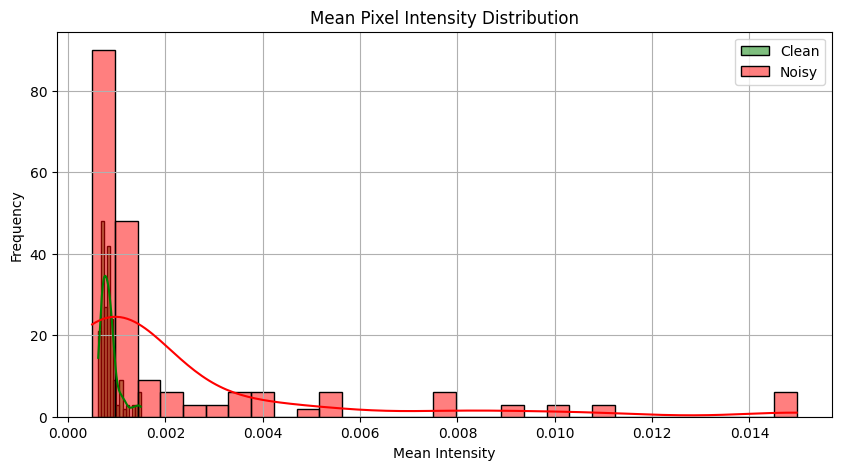

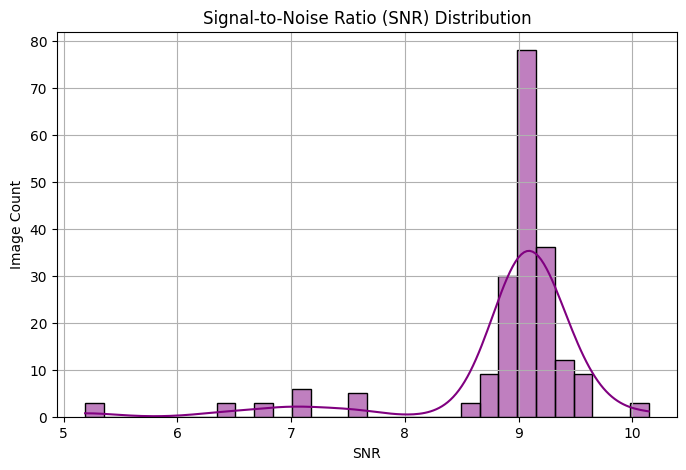

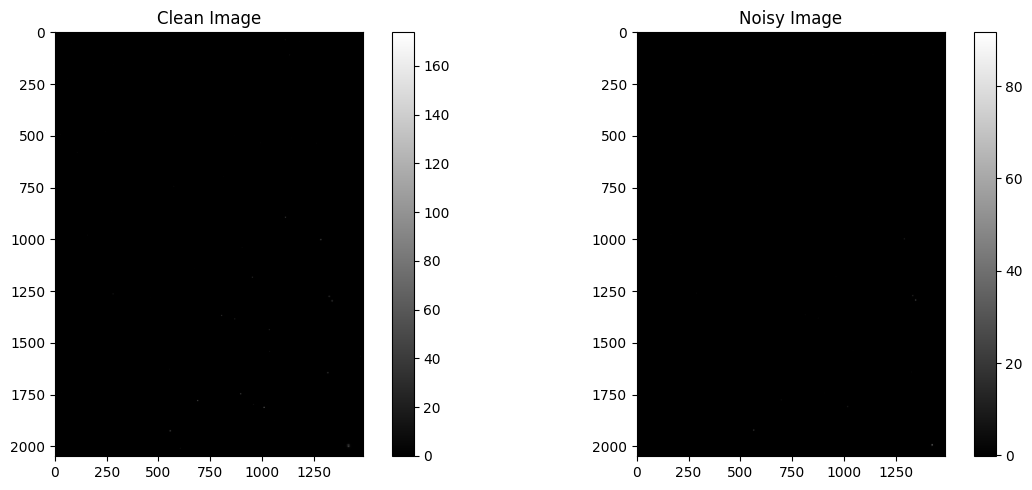

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import seaborn as sns

# Paths
clean_path = "/content/drive/MyDrive/sdss_image_dataset/augment_set3/clean"
noisy_path = "/content/drive/MyDrive/sdss_image_dataset/augment_set3/noisy"

# Collect file names
clean_files = sorted([f for f in os.listdir(clean_path) if f.endswith(".fits")])
noisy_files = sorted([f for f in os.listdir(noisy_path) if f.endswith(".fits")])

# Sample analysis over N images
N = 200
clean_means, noisy_means = [], []
clean_stds, noisy_stds = [], []
snr_values = []

for i in range(min(N, len(clean_files))):
    clean_img = fits.getdata(os.path.join(clean_path, clean_files[i]))
    noisy_img = fits.getdata(os.path.join(noisy_path, noisy_files[i]))

    # Normalization (optional)
    clean_img = (clean_img - np.min(clean_img)) / (np.max(clean_img) - np.min(clean_img) + 1e-8)
    noisy_img = (noisy_img - np.min(noisy_img)) / (np.max(noisy_img) - np.min(noisy_img) + 1e-8)

    # Basic statistics
    clean_means.append(np.mean(clean_img))
    noisy_means.append(np.mean(noisy_img))
    clean_stds.append(np.std(clean_img))
    noisy_stds.append(np.std(noisy_img))

    # SNR: Mean signal / standard deviation of background
    signal = np.percentile(noisy_img, 95)
    background = np.percentile(noisy_img, 5)
    noise = np.std(noisy_img[noisy_img < background])
    snr = (signal - background) / (noise + 1e-8)
    snr_values.append(snr)

plt.figure(figsize=(10, 5))
sns.histplot(clean_means, label="Clean", color="green", kde=True)
sns.histplot(noisy_means, label="Noisy", color="red", kde=True)
plt.title("Mean Pixel Intensity Distribution")
plt.xlabel("Mean Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(snr_values, bins=30, color="purple", kde=True)
plt.title("Signal-to-Noise Ratio (SNR) Distribution")
plt.xlabel("SNR")
plt.ylabel("Image Count")
plt.grid(True)
plt.show()

idx = 5  # pick any index

clean_img = fits.getdata(os.path.join(clean_path, clean_files[idx]))
noisy_img = fits.getdata(os.path.join(noisy_path, noisy_files[idx]))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(clean_img, cmap="gray")
plt.title("Clean Image")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(noisy_img, cmap="gray")
plt.title("Noisy Image")
plt.colorbar()

plt.tight_layout()
plt.show()


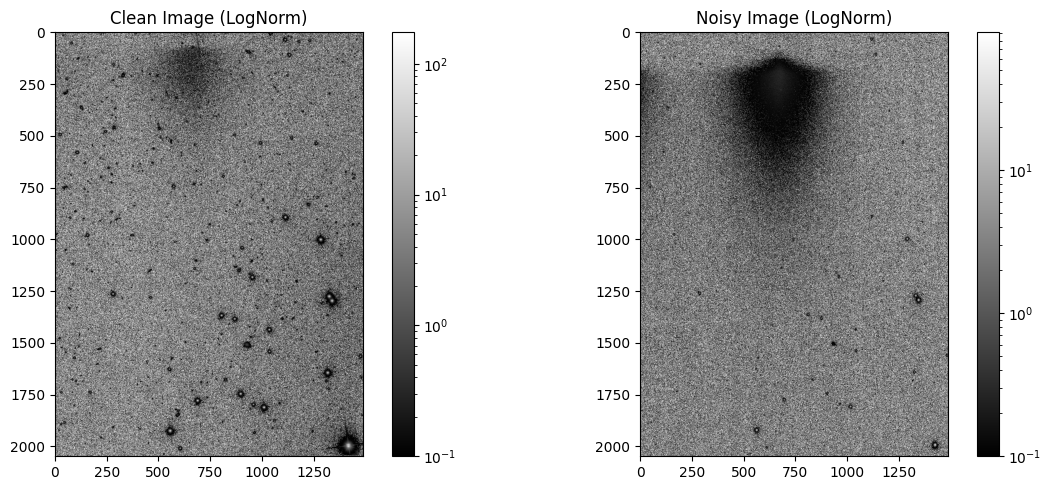

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits
import os

# Load the FITS image
idx = 5  # example index
clean_img = fits.getdata(os.path.join(clean_path, clean_files[idx]))
noisy_img = fits.getdata(os.path.join(noisy_path, noisy_files[idx]))

# Display with logarithmic normalization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(clean_img, cmap='gray', norm=LogNorm(vmin=1e-1, vmax=clean_img.max()))
plt.title("Clean Image (LogNorm)")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(noisy_img, cmap='gray', norm=LogNorm(vmin=1e-1, vmax=noisy_img.max()))
plt.title("Noisy Image (LogNorm)")
plt.colorbar()

plt.tight_layout()
plt.show()


In [ ]:
#convert fit into npy

In [ ]:
import os
import glob
import numpy as np
from astropy.io import fits
from tqdm import tqdm

# ── USER CONFIG ────────────────────────────────────────────────────────
CLEAN_FITS_DIR = "/content/drive/MyDrive/sdss_image_dataset/augment_set3/clean"
NOISY_FITS_DIR = "/content/drive/MyDrive/sdss_image_dataset/augment_set3/noisy"
OUT_BASE_DIR  = "/content/drive/MyDrive/sdss_image_dataset/augment_set3/npy_file"
#                                                                         #
# ── END USER CONFIG ────────────────────────────────────────────────────

# derive output subdirs
OUT_CLEAN = os.path.join(OUT_BASE_DIR, "clean")
OUT_NOISY = os.path.join(OUT_BASE_DIR, "noisy")
os.makedirs(OUT_CLEAN, exist_ok=True)
os.makedirs(OUT_NOISY, exist_ok=True)

def key_from_fname(fname: str, noisy: bool):
    """
    Given 'frame-r-1035-1-103_rot90.fits' or 'frame-u-1035-1-103_rot90.fits',
    return the shared key '1035-1-103_rot90'.
    """
    base = os.path.basename(fname)
    # strip the 'frame-r-' or 'frame-u-' prefix and the '.fits' suffix
    core = base.replace("frame-r-", "").replace("frame-u-", "")
    return os.path.splitext(core)[0]

# build dicts of full paths by key
clean_map = { key_from_fname(p, False): p
              for p in glob.glob(os.path.join(CLEAN_FITS_DIR, "*.fits")) }
noisy_map = { key_from_fname(p, True):  p
              for p in glob.glob(os.path.join(NOISY_FITS_DIR, "*.fits")) }

# intersect keys
all_keys = sorted(set(clean_map) & set(noisy_map))
print(f"Found {len(all_keys)} paired FITS to convert.")

# will collect any that fail
broken = []

for key in tqdm(all_keys, desc="converting", ncols=80):
    cpath = clean_map[key]
    npath = noisy_map[key]
    try:
        # load both
        cdat = fits.getdata(cpath).astype(np.float32)
        ndat = fits.getdata(npath).astype(np.float32)
        # handle any nans/infs
        cdat = np.nan_to_num(cdat, nan=0.0, posinf=0.0, neginf=0.0)
        ndat = np.nan_to_num(ndat, nan=0.0, posinf=0.0, neginf=0.0)

        # build output filenames
        out_clean = os.path.join(OUT_CLEAN, f"{key}.npy")
        out_noisy = os.path.join(OUT_NOISY, f"{key}.npy")

        # save
        np.save(out_clean, cdat)
        np.save(out_noisy, ndat)

    except Exception as e:
        # log and skip
        broken.append((key, str(e)))

# done
print()
print(f"✅ Conversion complete.  Successfully saved {len(all_keys)-len(broken)} pairs.")
if broken:
    print(f"⚠️ {len(broken)} failed:")
    for k, err in broken:
        print(f"  • {k}  → {err}")


Found 3147 paired FITS to convert.


converting:   1%|▎                          | 31/3147 [01:43<2:53:16,  3.34s/it]